In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import relative_finding

from cyvcf2 import VCF
from tqdm.notebook import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


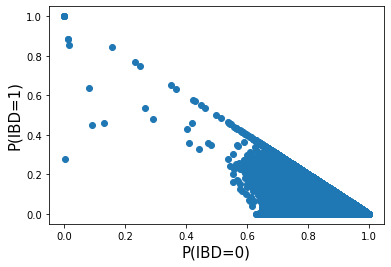

In [2]:
ibd = pd.read_pickle("sample/ibd.genome.pkl", compression='gzip')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(ibd["Z0"], ibd["Z1"])
ax.set_xlabel("P(IBD=0)", size=15)
ax.set_ylabel("P(IBD=1)", size=15)
plt.show()

In [3]:
filename = "sample/ALL.chr15.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
num_samples = 1500

actual = np.zeros((num_samples, 3))
pred = np.zeros((num_samples, 3))

for i, sample in tqdm(enumerate(ibd.sample(num_samples).itertuples()), total=num_samples):
    p0, p1, p2 = relative_finding.app(filename, sample.IID1, sample.IID2)
    pred[i, 0] = p0
    pred[i, 1] = p1
    pred[i, 2] = p2
    actual[i, 0] = sample.Z0
    actual[i, 1] = sample.Z1
    actual[i, 2] = sample.Z2
    
    if i % 100 == 0:
        np.save(f'ckpt{i}_actual.npy', actual[:i])
        np.save(f'ckpt{i}_pred.npy', pred[:i])

  0%|          | 0/1500 [00:00<?, ?it/s]

In [3]:
actual = np.load('ckpt1500_actual.npy')
pred = np.load('ckpt1500_pred.npy')

In [4]:
mae = np.sum(abs(pred - actual)) / pred.shape[0]
mse = np.sum((pred - actual) ** 2) / pred.shape[0]

print(f"mae: {mae}")
print(f"mse: {mse}")

mae: 0.00924104411615941
mse: 0.0006712319403097077


The majority of records are where one of the values is 1 while the rest are 0s. We can replicate these results perfectly. So, to see what our results for the rest of the data is like, we can filter these records out. 

In [5]:
print(len(ibd[(ibd['Z0'] == 1) | (ibd['Z1'] == 1) | (ibd['Z2'] == 1)]) / len(ibd))

0.8220502808770052


In [6]:
filter_1s = [False if np.any(i == 1) else True for i in pred]
filter_pred = pred[filter_1s]
filter_actual = actual[filter_1s]

In [7]:
mae = np.sum(abs(filter_pred - filter_actual)) / filter_pred.shape[0]
mse = np.sum((filter_pred - filter_actual) ** 2) / filter_pred.shape[0]

print(f"mae: {mae}")
print(f"mse: {mse}")

mae: 0.04514011330839444
mse: 0.0016106532054742926
